We are interested in generating meaningful interpolations and extrapolations based on the learned letterforms. therefore we start by evaluating the model's ability to interpolate between different variations in the same writing system such as weight (thickness), size, rotation, slant and style (font family). we then explore the extrapolation capabilities between letterforms of different writing systems.

We compare models with different latent dimensions and other hyperparameters. we also compare the results of the models trained on different datasets with different levels of augmentation.

In [1]:
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
MODELS_DIR = './results/experiment 3/models/'

%matplotlib inline
%load_ext autoreload
%autoreload 2



# Load Pre-Trained Models

In [2]:
from src.capsnet import CapsNet
from configs.config import capsnet_config
from configs.config import dotdict

def get_model_name(conf, ds_type, letter):
    rc = conf.reconstruction_coeff
    model_name = f"capsnet_{ds_type}_{letter}_rc{rc}"
    return model_name

def load_capsnet(conf, ds_type, letter, device):
    capsnet = CapsNet(conf)
    model_name = get_model_name(conf, ds_type, letter)
    # load on cpu
    capsnet.load_state_dict(torch.load(MODELS_DIR + model_name + ".pt", map_location=device))
    return capsnet

example_config = capsnet_config
example_config.reconstruction_coeff = 1.0

example_letter = 'aleph'
heb_char = 'א'
ar_char = 'أ'
geez_char = 'አ'

# example_letter = "qoph"
# heb_char = 'ק'
# ar_char = 'ق'
# geez_char = 'ቀ'

example_capsnet = load_capsnet(example_config, 'rotation', example_letter, device)

In [3]:
# hyperparameter ranges for model evaluation
reconstruction_coeffs = [1.0]
letters = [example_letter]
ds_types = ["base", "moderate", "rotation"]

In [4]:
import itertools 

models = {}

for ds_type, letter, rc in itertools.product(ds_types, letters, reconstruction_coeffs):
    conf = capsnet_config
    conf.reconstruction_coeff 
    model = CapsNet(conf)
    model_name = get_model_name(conf, ds_type, letter)
    model.load_state_dict(torch.load(os.path.join(MODELS_DIR, model_name + ".pt"),map_location=device))
    model.eval()
    models[model_name] = model

In [5]:
example_capsnet.load_state_dict(torch.load("./pretrained_models/capsnet_aleph.pth", map_location=device))
example_capsnet.eval()
models["example"] = example_capsnet

# Load base dataset
this is a dataset where all letters are centered, not rotated and with a fixed size.

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms
from src.datasets import GraphemesDataset
data_dir = "datasets/base_dataset/"

img_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = GraphemesDataset(data_dir, test_size=0, by_letter=example_letter, transform=img_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


# Explore the latent representations of the base dataset

In [7]:
# convert all images to their latent representation using the encoder

# images will be a list of all images in the dataset in the same order as the labels and latent_representations lists
# you should add all images from all batches to the list and make sure to
# convert it to PIL images of 28 x 28

from PIL import Image        


def get_latent_representation(capsnet, dataloader, device):
    images = []
    reconstructions = []
    latent_representations = []
    labels = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):

            for tensor in x:
                # Remove the batch dimension and convert the tensor to a numpy array
                image_np = tensor.squeeze().cpu().numpy()
                # Convert numpy array to PIL image
                pil_image = Image.fromarray((image_np * 255).astype('uint8'), mode='L')
                images.append(pil_image)

            x = x.to(device)
            output, recon, masked = capsnet(x)
            latent_representations.append(output)
            reconstructions.append(recon)
            labels.append(y)

    latent_representations = torch.cat(latent_representations).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    reconstructions = torch.cat(reconstructions).cpu().numpy()

    pil_reconstructions = []
    for img_np in reconstructions:
        img_np = img_np.squeeze() * 255
        pil_img = Image.fromarray(img_np.astype('uint8'), mode='L')
        pil_reconstructions.append(pil_img)

    return images, labels, latent_representations, pil_reconstructions

images, y, z, reconstructions = get_latent_representation(example_capsnet, dataloader, device)

If the latent dimension is bigger than 2, we can't visualize it.
We use tSNE to reduce the dimension to 2.

In [8]:
from sklearn.manifold import TSNE

if example_config.dc_out_channels > 2:
    tsne = TSNE(n_components=2, perplexity=15) 
    z_tsne = tsne.fit_transform(z.reshape(z.shape[0], -1))
    z = z_tsne

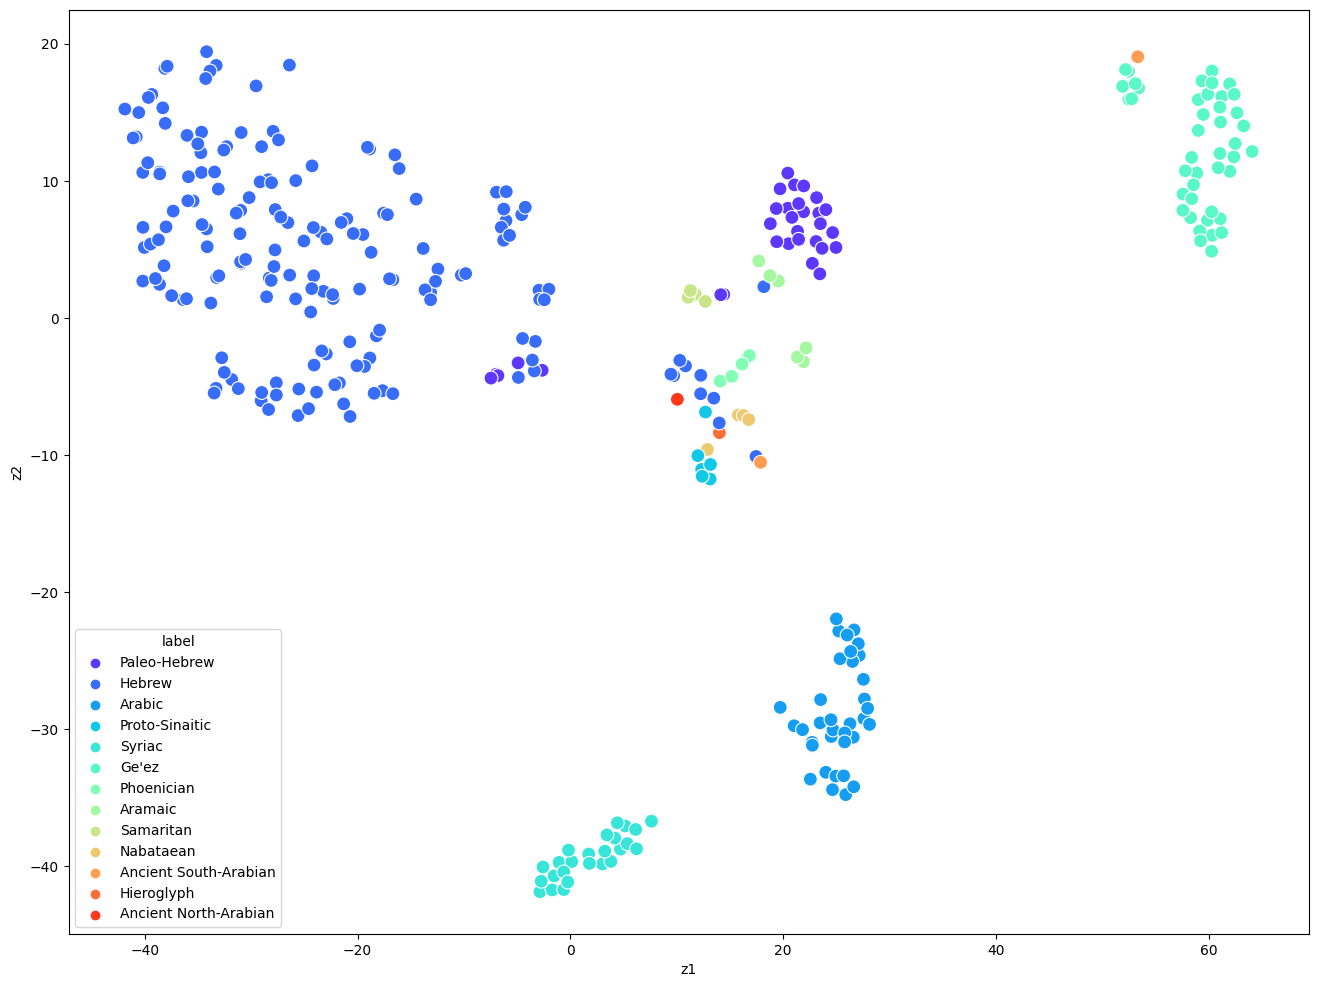

In [9]:
labels = [dataset.classes[i] for i in y]
data = pd.DataFrame({
    'z1': z[:, 0],
    'z2': z[:, 1],
    'label': labels
})
fig = plt.figure(figsize=(16, 12))
scatter = sns.scatterplot(x='z1', y='z2', hue='label', palette="rainbow", data=data, s=100)
plt.show() 


Plot original and reconstructed images according to their location in the latent space.

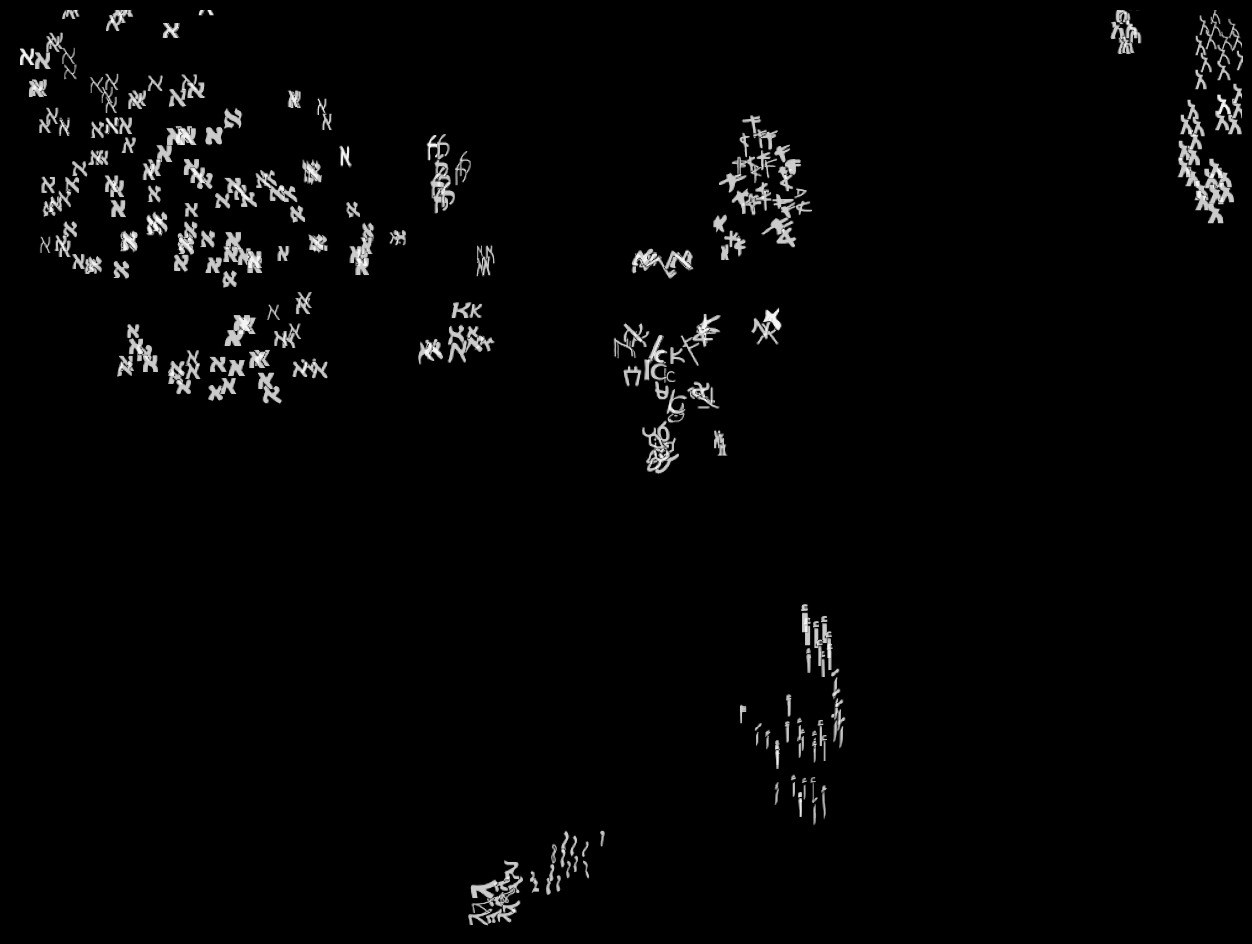

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images_with_coordinates(images, coordinates, width=1000, height=750):
    normalized_x, normalized_y = coordinates[:, 0], coordinates[:, 1]
    normalized_x = (normalized_x - np.min(normalized_x)) / (np.max(normalized_x) - np.min(normalized_x))
    normalized_y = (normalized_y - np.min(normalized_y)) / (np.max(normalized_y) - np.min(normalized_y))

    plt.figure(figsize=(16, 12), facecolor='black')

    for grapheme, norm_x, norm_y in zip(images, normalized_x, normalized_y):
        grapheme_cv2 = cv2.cvtColor(np.array(grapheme), cv2.COLOR_RGBA2BGRA)

        gray = cv2.cvtColor(grapheme_cv2, cv2.COLOR_BGRA2GRAY)
        _, alpha = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

        b, g, r, _ = cv2.split(grapheme_cv2)
        rgba = [b, g, r, alpha]
        grapheme_no_bg = cv2.merge(rgba, 4)

        x_coord = int(width * norm_x)
        y_coord = int(height * norm_y)

        plt.imshow(grapheme_no_bg, extent=[x_coord, x_coord + grapheme.width, y_coord, y_coord + grapheme.height], alpha=0.8)

    plt.xlim(0, width)
    plt.ylim(0, height)

    plt.axis('off')
    plt.grid(False)

    plt.show()

# Example usage
plot_images_with_coordinates(images, z)


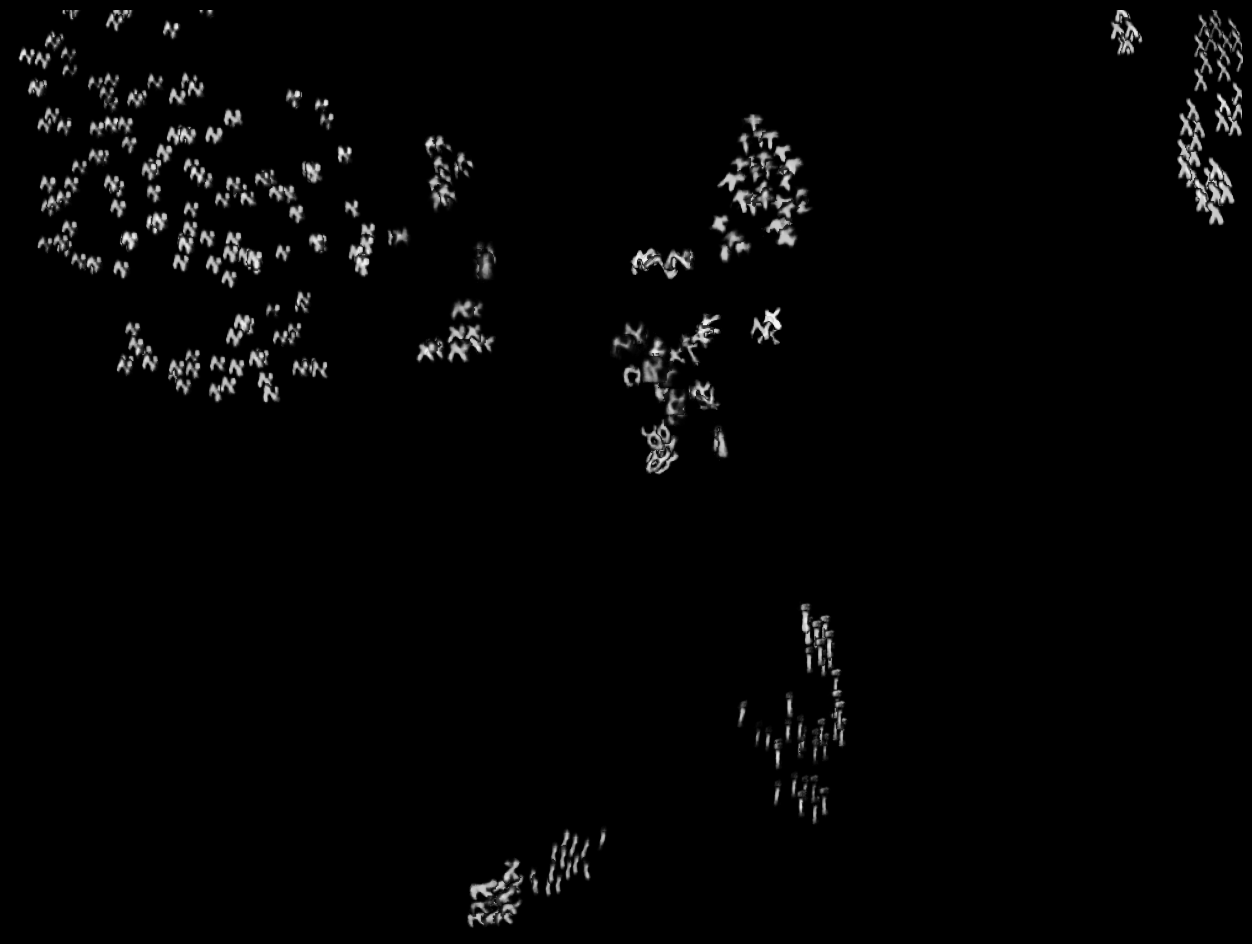

In [11]:
plot_images_with_coordinates(reconstructions, z)


plot the bounding area of the latent representations (only for 2d latent space)

In [12]:
# plot a visual grid of the latent space in the bounding area of the training data.
# only works for 2D latent space
if example_config.dc_out_channels == 2:

    # calculate the bounding box in the latent space
    latent_bbox = np.asarray([np.min(z, axis=0), np.max(z, axis=0)])

    grid_resolution = np.asarray((1000/28, 750/28), dtype=int)

    with torch.no_grad():
        latent_x = np.linspace(latent_bbox[0, 0], latent_bbox[1, 0], grid_resolution[0])
        latent_y = np.linspace(latent_bbox[0, 1], latent_bbox[1, 1], grid_resolution[1])
        latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)

        for i, lx in enumerate(latent_x):
            for j, ly in enumerate(latent_y):
                latents[j, i, 0] = lx
                latents[j, i, 1] = ly
        latents = latents.view(-1, 2)

        latents = latents.to(device)
        image_recon = example_vae.decoder(latents)
        image_recon = image_recon.cpu().numpy()
        pil_reconstructions = []
        for img_np in image_recon:
            img_np = img_np.squeeze() * 255
            pil_img = Image.fromarray(img_np.astype('uint8'), mode='L')
            pil_reconstructions.append(pil_img)

    plot_images_with_coordinates(pil_reconstructions, latents.numpy())


# Latent Space Interpolation

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def interpolation(lambda1, model, img1, img2):
    with torch.no_grad():
        img1 = img1.to(device)
        latent_1, reconstructions_1, masked_1= model(img1)

        img2 = img2.to(device)
        latent_2, reconstructions_2, masked_2 = model(img2)

        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2
        inter_image = model.decoder(inter_latent)[0]
        inter_image = inter_image.cpu()

        return reconstructions_1

def plot_interpolation(models, n_steps, img1, img2):
    model_names = list(models.keys())
    n_models = len(model_names)
    lambda_range = np.linspace(0, 1, n_steps)

    fig, axs = plt.subplots(n_models, n_steps, figsize=(n_steps, n_models))

    for i, model_name in enumerate(model_names):
        axs[i][0].text(-0.5, 0.5, model_name, fontsize=12, ha='right', va='center')
        for j, l in enumerate(lambda_range):
            inter_image = interpolation(float(l), models[model_name], img1, img2)
            img_np = inter_image.numpy()
            img_np = img_np.squeeze() * 255
            pil_img = Image.fromarray(img_np.astype('uint8'), mode='L')
            axs[i][j].imshow(pil_img, cmap='gray')
            axs[i][j].axis('off')
            axs[i][j].grid(False)
    plt.show()


# Interpolate between letter variations

to evaluate the model's interpolation we choose image pairs that are different in:
* weight (thickness)
* size
* translation
* rotation
* slant (italic)
* style (font family)

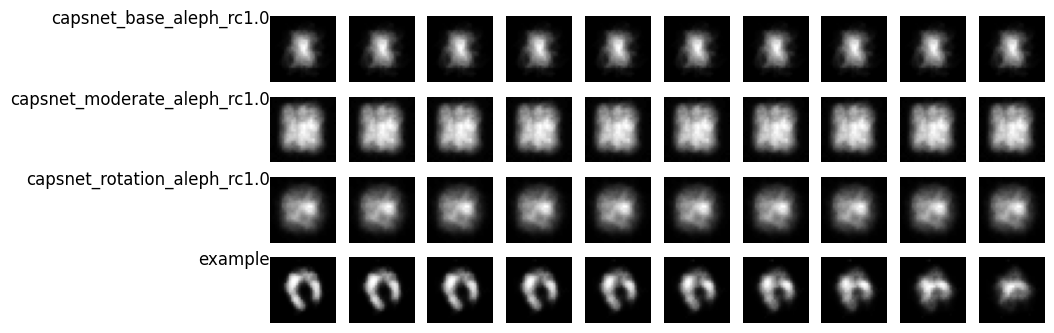

In [33]:
# Weight 
x, y = next(iter(dataloader))
img1 = x[0].unsqueeze(0)
img2 = x[1].unsqueeze(0)
plot_interpolation(models, 10, img1, img2)

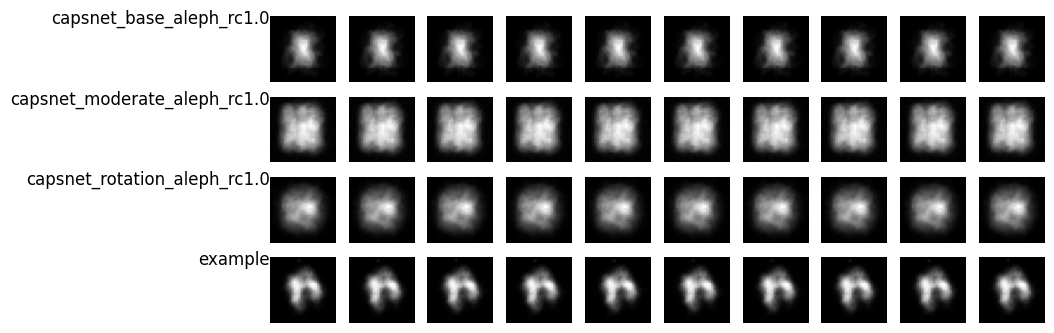

In [14]:
# Weight 
thin_path = f"datasets/base_dataset/{example_letter}/Hebrew/{example_letter}_Hebrew_NotoSansHebrew-Thin_{heb_char}_22_0.0.png"
thick_path = f"datasets/base_dataset/{example_letter}/Hebrew/{example_letter}_Hebrew_NotoSansHebrew-Black_{heb_char}_22_0.0.png"

# load images and convert to tensors, then call plot_interpolation
thin_img = Image.open(thin_path).convert('L')
thick_img = Image.open(thick_path).convert('L')
thin = transforms.ToTensor()(thin_img).unsqueeze(0)
thick = transforms.ToTensor()(thick_img).unsqueeze(0)
plot_interpolation(models, 10, thin, thick)

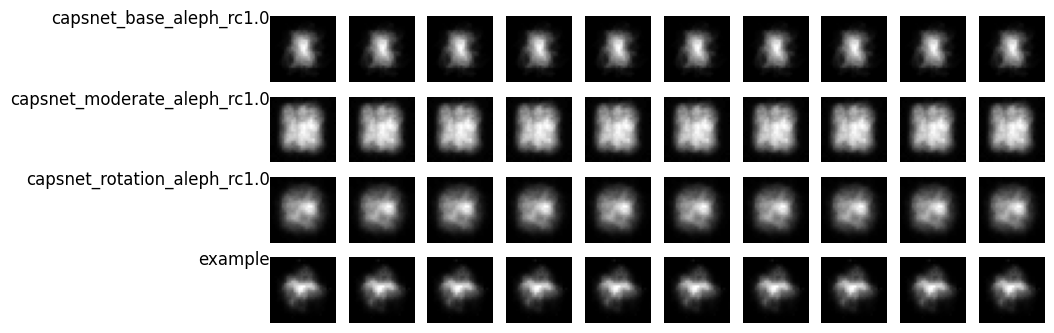

In [15]:
# Weight 
thin_path = f"datasets/base_dataset/{example_letter}/Ge'ez/{example_letter}_Ge'ez_NotoSansEthiopic-Thin_{geez_char}_22_0.0.png"
thick_path = f"datasets/base_dataset/{example_letter}/Ge'ez/{example_letter}_Ge'ez_NotoSansEthiopic-Black_{geez_char}_22_0.0.png"

# load images and convert to tensors, then call plot_interpolation
thin_img = Image.open(thin_path).convert('L')
thick_img = Image.open(thick_path).convert('L')
thin = transforms.ToTensor()(thin_img).unsqueeze(0)
thick = transforms.ToTensor()(thick_img).unsqueeze(0)
plot_interpolation(models, 10, thin, thick)

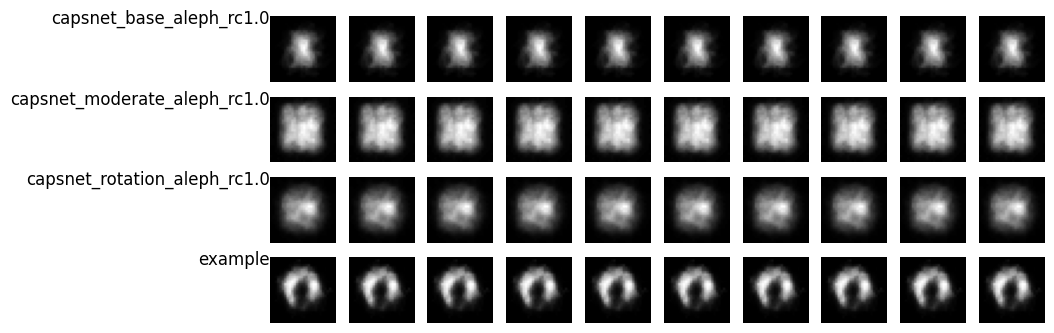

In [16]:
# Translation
left_path = f"datasets/moderate_dataset/{example_letter}/Arabic/aleph_Arabic_NotoKufiArabic-ExtraLight_أ_23_0.8197145669735337.png"
right_path = f"datasets/moderate_dataset/{example_letter}/Arabic/aleph_Arabic_NotoKufiArabic-Light_أ_22_-6.885105878513751.png"

# load images and convert to tensors, then call plot_interpolation
left_img = Image.open(left_path).convert('L')
right_img = Image.open(right_path).convert('L')
left = transforms.ToTensor()(left_img).unsqueeze(0)
right = transforms.ToTensor()(right_img).unsqueeze(0)
plot_interpolation(models, 10, right, left)

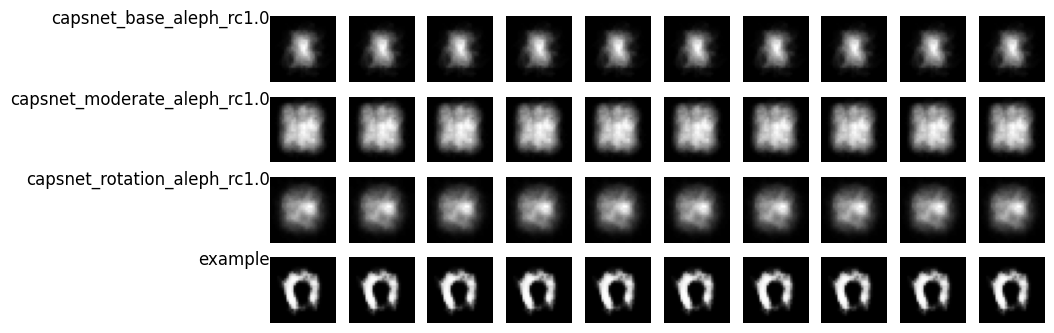

In [17]:
# Translation
small_path = f"datasets/moderate_dataset/{example_letter}/Hebrew/aleph_Hebrew_OS Aran_400FFC_א_25_2.715677593407859.png"
big_path = f"datasets/moderate_dataset/{example_letter}/Hebrew/aleph_Hebrew_miriwin-webfont_א_25_-5.702912909956729.png"

# load images and convert to tensors, then call plot_interpolation
small_img = Image.open(small_path).convert('L')
big_img = Image.open(big_path).convert('L')
small = transforms.ToTensor()(small_img).unsqueeze(0)
big = transforms.ToTensor()(big_img).unsqueeze(0)
plot_interpolation(models, 10, small, big)

# Extrapolate between writing systems

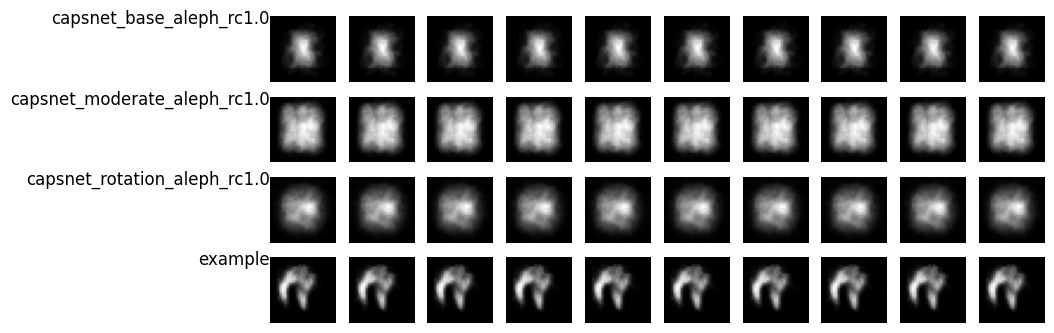

In [18]:
# sort part of test set by writing system
scripts = {script : [] for script in dataset.classes}
for img_batch, label_batch in dataloader:
    for i in range(img_batch.size(0)):
        scripts[dataset.classes[label_batch[i]]].append(img_batch[i:i+1])
    if sum(len(d) for d in scripts) >= 1000:
        break;

heb_img = scripts["Hebrew"][0]
ar_img = scripts["Arabic"][0]

# Example usage
n_steps = 10
plot_interpolation(models, n_steps, heb_img, ar_img)